Inspired/based on https://github.com/rayidghani/magicloops and https://github.com/dssg/MLforPublicPolicy/blob/master/labs/2019/lab6_feature_generation_sol.ipynb

In [181]:
import pipeline_evictions as pipeline
import ml_loop_evictions as loop

import importlib
import datetime
import pandas as pd
import numpy as np

# Read data

In [182]:
importlib.reload(pipeline)

datafile = "data/tracts.csv"

#Read data, parsing year column to date type
data = pd.read_csv(datafile, parse_dates=['year'])

# Basic Cleaning

In [183]:
# Delete rows that do not have eviction-rate. We do not want to impute this value

data.dropna(subset=['eviction-rate'], inplace=True)
data['eviction-rate'].isnull().values.any()
data.reset_index(inplace=True, drop=True)

# Create outcome label

In [184]:
def get_eviction_rate(df, year,geoid):
    
  data_to_return = df.loc[(df['year'] == year) & (df['GEOID'] == geoid)]
  
  if(data_to_return.empty):
    return 0
  
  return data_to_return['eviction-rate'].iloc[0]

In [ ]:
importlib.reload(pipeline)

from dateutil.relativedelta import relativedelta

#Obtain eviction-rate cutoff for the top 10%, for each year
cutoff_10_percent={}
for year in range(2000,2017):
    year = pd.Timestamp(year,1,1)
    cutoff_10_percent[year]=data.loc[data['year'] == year]['eviction-rate'].quantile(.9)
    
top_10_eviction_rate_in_any_next_3_years_column = np.zeros(len(data))
print(top_10_eviction_rate_in_any_next_3_years_column.shape)

#Generate this feature now
# top_10_eviction_rate_last_year_column = np.zeros(len(data))

for index, row in data.iterrows():
  
  #Because the outcome will come from eviction-rate in next 3 years and we have data till 2016,
  #features data bust be from 2013 or before
  
  #We will also limit rows so that they all have one year before them (to calculate to_10_previous_year_feature)
  # & row['year']>=pd.Timestamp(2001,1,1)
  if(row['year']<=pd.Timestamp(2013,1,1)):    
    
    found_year_where_eviction_was_in_top_10_percent=0
    
    #Get eviction for the next 3 years
    for i in range(1,4):
      date_in_i_years = row['year'] + relativedelta(years=i)
      eviction_rate_in_i_years = get_eviction_rate(data, date_in_i_years,row['GEOID'])
    
      top_10_eviction_rate_in_i_years = 1 if eviction_rate_in_i_years>= cutoff_10_percent[date_in_i_years] else 0
      

      
      #If we found one year that meets requirement, we are done with looping
      if(top_10_eviction_rate_in_i_years==1):
        found_year_where_eviction_was_in_top_10_percent=1
        break

    top_10_eviction_rate_in_any_next_3_years_column[index]=found_year_where_eviction_was_in_top_10_percent

    
    #Generating feature now
#     date_last_years = row['year'] - relativedelta(years=i)
#     eviction_rate_last_year = get_eviction_rate(data, date_last_years,row['GEOID'])
#     top_10_eviction_rate_last_year = 1 if eviction_rate_last_year>= cutoff_10_percent[date_last_years] else 0

#     top_10_eviction_rate_last_year_column[index] = top_10_eviction_rate_last_year
    
    
data['top_10_percent_in_any_next_3_years'] = top_10_eviction_rate_in_any_next_3_years_column

label ='top_10_percent_in_any_next_3_years'

#Feature
# data['top_10_percent_last_year']=top_10_eviction_rate_last_year_column



In [186]:
#Debugging. In case we want to add 1 column for each future year with top 10%

      # eviction_rate_in_1_year = np.zeros(len(data))
# cutoff_in_1_year = np.zeros(len(data))

      
#       if(top_10_eviction_rate_in_i_years==1):
#         print(row['GEOID'])
#         print(row['year'])
#         print(date_in_i_years)
#         print(eviction_rate_in_i_years)
#         print(cutoff_10_percent[date_in_i_years])
#         print(top_10_eviction_rate_in_i_years)     

#       if(i==1):
#         eviction_rate_in_1_year[index]=eviction_rate_in_i_years
#         cutoff_in_1_year[index]=cutoff_10_percent[date_in_i_years]

# data['eviction_rate_in_1_year']='eviction_rate_in_1_year'
# data['cutoff_in_1_year']='eviction_rate_in_1_year'      
    

# Create temporal train and test sets

In [187]:
importlib.reload(pipeline)

#Create sets of train and test data, based on different split thresholds
#The split thresholds corresponds to the starting date of the testing data

#Splits according to https://docs.google.com/spreadsheets/d/1ipqsgThz7hdXXyyNpTuqa4J1inc088lop7lhFsAQ_r0/edit#gid=0
split_thresholds = [pd.Timestamp(i,1,1) for i in range (2004, 2014)]

#Indicating which is the column to be used for splitting training and test daata
date_column='year'

#Amount of data used for test set
test_window = relativedelta(years=4)

#Gap needed between training and test set
prediction_horizon = relativedelta(years=3)

#Generate train and test sets
train_test_sets= pipeline.create_temp_validation_train_and_testing_sets(
  data,
  date_column,
  label,
  split_thresholds,
  test_window,
  prediction_horizon)

In [188]:
for c in train_test_sets[5]['x_train'].columns:
  print(c)

GEOID
year
name
parent-location
population
poverty-rate
renter-occupied-households
pct-renter-occupied
median-gross-rent
median-household-income
median-property-value
rent-burden
pct-white
pct-af-am
pct-hispanic
pct-am-ind
pct-asian
pct-nh-pi
pct-multiple
pct-other
eviction-filings
evictions
eviction-rate
eviction-filing-rate
low-flag
imputed
subbed


# Imputation

In [189]:
importlib.reload(pipeline)

#Impute data on continuous columns for each training and test set

#--->PENDING
#In the meantime, imputing all float columns with mean
  
float_columns = [column for column in data.columns if data[column].dtype=='float']

#Do not consider GEOID column nor top_10_percent_in_any_next_3_years
float_columns.remove('name')
float_columns.remove('top_10_percent_in_any_next_3_years')


for train_test_set in train_test_sets:
  train_data = train_test_set['x_train']
  test_data = train_test_set['x_test']

  #fill na values with mean
  pipeline.impute_data(train_data, float_columns)
  pipeline.impute_data(test_data, float_columns)


# Create features

In [190]:
import feature_generation as fg

importlib.reload(pipeline)
importlib.reload(fg)

#We will have to generate features independently for each different train/test set
for train_test_set in train_test_sets:

  train_features = fg.create_features(train_test_set['x_train'])
  test_features = fg.create_features(train_test_set['x_test']) 
  
  #Alternative for just working with default features
  #train_features, test_features = pipeline.create_features(train_test_set)
  
  #Replace raw data in train_test_set with features generated
  train_test_set['x_train'] = train_features
  train_test_set['x_test'] = test_features
  

# Build Clasifiers and parameters generation

In [249]:
importlib.reload(pipeline)

#We define the specific models we want to run
models_to_run=['Baseline','DT','LR','RF','NB','BA','AB','GB']#,ET,KNN,SVM'

#Get all posible models and their different sets of parameters
models, parameters_grid = pipeline.get_models_and_parameters('small')

# Loop over models and different training/test sets

In [250]:
# # print(len(train_test_sets[0]['x_test']))
# # print(len(train_test_sets[0]['y_test']))
# train_test_sets[0]['y_test'].isnull().any()
# # df.isnull().values.any()

# # for column in train_test_sets[5]['x_test'].columns:
# #   print(column)
# #   
# train_test_sets[5]['x_train'].to_csv("columns.csv")


In [251]:
importlib.reload(pipeline)
importlib.reload(loop)

import warnings

warnings.filterwarnings('ignore')

results = loop.iterate_over_models_and_training_test_sets(models_to_run, models, parameters_grid, train_test_sets)
results

2019-06-12 12:16:39.391763: Running Baseline with params: {} on train/test set 2004-01-01 00:00:00
2019-06-12 12:16:39.977862: Running DT with params: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2} on train/test set 2004-01-01 00:00:00
2019-06-12 12:16:40.332184: Running DT with params: {'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 2} on train/test set 2004-01-01 00:00:00
2019-06-12 12:16:41.045705: Running DT with params: {'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 2} on train/test set 2004-01-01 00:00:00
2019-06-12 12:16:41.477932: Running LR with params: {'C': 0.1, 'penalty': 'l1'} on train/test set 2004-01-01 00:00:00
2019-06-12 12:16:42.383059: Running LR with params: {'C': 0.1, 'penalty': 'l2'} on train/test set 2004-01-01 00:00:00
2019-06-12 12:16:43.202484: Running LR with params: {'C': 10, 'penalty': 'l1'} on train/test set 2004-01-01 00:00:00
2019-06-12 12:17:04.143561: Running LR with params: {'C': 10, 'penalty': 'l2'} on train/t

2019-06-12 12:20:31.530818: Running RF with params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2006-01-01 00:00:00
2019-06-12 12:20:32.372730: Running RF with params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} on train/test set 2006-01-01 00:00:00
2019-06-12 12:20:33.083332: Running RF with params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2006-01-01 00:00:00
2019-06-12 12:20:34.102275: Running NB with params: {} on train/test set 2006-01-01 00:00:00
2019-06-12 12:20:34.535118: Running BA with params: {'n_estimators': 10} on train/test set 2006-01-01 00:00:00
2019-06-12 12:20:36.478362: Running BA with params: {'n_estimators': 100} on train/test set 2006-01-01 00:00:00
2019-06-12 12:20:54.649982: Running AB with params: {'algorithm': 'SAMME', 'n_estimators': 10} on train/test set 

2019-06-12 12:28:52.964157: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 100} on train/test set 2008-01-01 00:00:00
2019-06-12 12:28:56.398076: Running GB with params: {'learning_rate': 0.1, 'n_estimators': 10} on train/test set 2008-01-01 00:00:00
2019-06-12 12:28:57.099110: Running GB with params: {'learning_rate': 0.1, 'n_estimators': 100} on train/test set 2008-01-01 00:00:00
2019-06-12 12:29:00.259359: Running ET with params: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100} on train/test set 2008-01-01 00:00:00
2019-06-12 12:29:00.907413: Running ET with params: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100} on train/test set 2008-01-01 00:00:00
2019-06-12 12:29:01.750266: Running ET with params: {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 100} on train/test set 2008-01-01 00:00:00
2019-06-12 12:29:02.771695: Running ET with params: {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 100} on train/test set 2008-01-01 00:00:00

2019-06-12 12:36:36.680890: Running DT with params: {'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 2} on train/test set 2011-01-01 00:00:00
2019-06-12 12:36:37.449855: Running DT with params: {'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 2} on train/test set 2011-01-01 00:00:00
2019-06-12 12:36:38.261075: Running LR with params: {'C': 0.1, 'penalty': 'l1'} on train/test set 2011-01-01 00:00:00
2019-06-12 12:36:46.728186: Running LR with params: {'C': 0.1, 'penalty': 'l2'} on train/test set 2011-01-01 00:00:00
2019-06-12 12:36:48.477646: Running LR with params: {'C': 10, 'penalty': 'l1'} on train/test set 2011-01-01 00:00:00
2019-06-12 12:39:53.247967: Running LR with params: {'C': 10, 'penalty': 'l2'} on train/test set 2011-01-01 00:00:00
2019-06-12 12:39:55.177040: Running RF with params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} on train/test set 2011-01-01 00:00:00
2019-06-12 12:39:55.740662: Runnin

2019-06-12 12:49:58.851511: Running RF with params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2013-01-01 00:00:00
2019-06-12 12:50:00.948404: Running NB with params: {} on train/test set 2013-01-01 00:00:00
2019-06-12 12:50:01.805214: Running BA with params: {'n_estimators': 10} on train/test set 2013-01-01 00:00:00
2019-06-12 12:50:10.609089: Running BA with params: {'n_estimators': 100} on train/test set 2013-01-01 00:00:00
2019-06-12 12:51:22.648264: Running AB with params: {'algorithm': 'SAMME', 'n_estimators': 10} on train/test set 2013-01-01 00:00:00
2019-06-12 12:51:24.083657: Running AB with params: {'algorithm': 'SAMME', 'n_estimators': 100} on train/test set 2013-01-01 00:00:00
2019-06-12 12:51:30.401261: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 10} on train/test set 2013-01-01 00:00:00
2019-06-12 12:51:31.381616: Running GB with params: {'learning_rate': 0.001, 'n_estimators'

,model_name,model,parameters,test_set_start_date,baseline,p_at_1,r_at_1,f1_at_1,p_at_2,r_at_2,...,p_at_20,r_at_20,f1_at_20,p_at_30,r_at_30,f1_at_30,p_at_50,r_at_50,f1_at_50,auc-roc
0,Baseline,Baseline model,{},2004-01-01,0.139671,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.042553,0.060837,0.050078,0.069149,0.148289,0.094317,0.053135,0.190114,0.083056,0.500000
1,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 2, 'min_sam...",2004-01-01,0.139671,0.833333,0.057034,0.106762,0.837838,0.117871,...,0.545213,0.779468,0.641628,0.397163,0.851711,0.541717,0.265675,0.950570,0.415282,0.912381
2,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 50, 'min_sa...",2004-01-01,0.139671,0.444444,0.030418,0.056940,0.405405,0.057034,...,0.497340,0.711027,0.585290,0.365248,0.783270,0.498186,0.228480,0.817490,0.357143,0.826512
3,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 100, 'min_s...",2004-01-01,0.139671,0.444444,0.030418,0.056940,0.405405,0.057034,...,0.497340,0.711027,0.585290,0.365248,0.783270,0.498186,0.228480,0.817490,0.357143,0.826512
4,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.1, 'penalty': 'l1'}",2004-01-01,0.139671,0.777778,0.053232,0.099644,0.675676,0.095057,...,0.550532,0.787072,0.647887,0.427305,0.916350,0.582830,0.268863,0.961977,0.420266,0.920208
5,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.1, 'penalty': 'l2'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,0.972973,0.136882,...,0.590426,0.844106,0.694836,0.439716,0.942966,0.599758,0.277365,0.992395,0.433555,0.953185
6,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 10, 'penalty': 'l1'}",2004-01-01,0.139671,0.888889,0.060837,0.113879,0.891892,0.125475,...,0.550532,0.787072,0.647887,0.423759,0.908745,0.577993,0.265675,0.950570,0.415282,0.924842
7,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 10, 'penalty': 'l2'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,1.000000,0.140684,...,0.601064,0.859316,0.707355,0.443262,0.950570,0.604595,0.277365,0.992395,0.433555,0.958478
8,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2004-01-01,0.139671,1.000000,0.068441,0.128114,1.000000,0.140684,...,0.569149,0.813688,0.669797,0.427305,0.916350,0.582830,0.268863,0.961977,0.420266,0.933187
9,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2004-01-01,0.139671,1.000000,0.068441,0.128114,0.972973,0.136882,...,0.587766,0.840304,0.691706,0.429078,0.920152,0.585248,0.273114,0.977186,0.426910,0.943213


<Figure size 432x288 with 0 Axes>

# Observe best models for each train/test set, for different metrics

In [252]:
results

,model_name,model,parameters,test_set_start_date,baseline,p_at_1,r_at_1,f1_at_1,p_at_2,r_at_2,...,p_at_20,r_at_20,f1_at_20,p_at_30,r_at_30,f1_at_30,p_at_50,r_at_50,f1_at_50,auc-roc
0,Baseline,Baseline model,{},2004-01-01,0.139671,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.042553,0.060837,0.050078,0.069149,0.148289,0.094317,0.053135,0.190114,0.083056,0.500000
1,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 2, 'min_sam...",2004-01-01,0.139671,0.833333,0.057034,0.106762,0.837838,0.117871,...,0.545213,0.779468,0.641628,0.397163,0.851711,0.541717,0.265675,0.950570,0.415282,0.912381
2,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 50, 'min_sa...",2004-01-01,0.139671,0.444444,0.030418,0.056940,0.405405,0.057034,...,0.497340,0.711027,0.585290,0.365248,0.783270,0.498186,0.228480,0.817490,0.357143,0.826512
3,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 100, 'min_s...",2004-01-01,0.139671,0.444444,0.030418,0.056940,0.405405,0.057034,...,0.497340,0.711027,0.585290,0.365248,0.783270,0.498186,0.228480,0.817490,0.357143,0.826512
4,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.1, 'penalty': 'l1'}",2004-01-01,0.139671,0.777778,0.053232,0.099644,0.675676,0.095057,...,0.550532,0.787072,0.647887,0.427305,0.916350,0.582830,0.268863,0.961977,0.420266,0.920208
5,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.1, 'penalty': 'l2'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,0.972973,0.136882,...,0.590426,0.844106,0.694836,0.439716,0.942966,0.599758,0.277365,0.992395,0.433555,0.953185
6,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 10, 'penalty': 'l1'}",2004-01-01,0.139671,0.888889,0.060837,0.113879,0.891892,0.125475,...,0.550532,0.787072,0.647887,0.423759,0.908745,0.577993,0.265675,0.950570,0.415282,0.924842
7,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 10, 'penalty': 'l2'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,1.000000,0.140684,...,0.601064,0.859316,0.707355,0.443262,0.950570,0.604595,0.277365,0.992395,0.433555,0.958478
8,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2004-01-01,0.139671,1.000000,0.068441,0.128114,1.000000,0.140684,...,0.569149,0.813688,0.669797,0.427305,0.916350,0.582830,0.268863,0.961977,0.420266,0.933187
9,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2004-01-01,0.139671,1.000000,0.068441,0.128114,0.972973,0.136882,...,0.587766,0.840304,0.691706,0.429078,0.920152,0.585248,0.273114,0.977186,0.426910,0.943213


In [253]:
importlib.reload(pipeline)

#Lets obtain the best model for each train/test set, for each metric
metrics_to_display = ['p_at_5','p_at_10', 'auc-roc']

best_models_per_metric = {}

for metric in metrics_to_display:
    #indices of rows that have max value in specific metric for each train/test set
    idx = results.groupby(['test_set_start_date'])[metric].transform(max) == results[metric]

    #save table of best models at the specific metric
    best_models_per_metric[metric] = results[idx]

### Best models for Precision at 5%

In [254]:
best_models_per_metric['p_at_5'].iloc[:, [0,2,3,4,11,12,13]]

,model_name,parameters,test_set_start_date,baseline,p_at_5,r_at_5,f1_at_5
7,LR,"{'C': 10, 'penalty': 'l2'}",2004-01-01,0.139671,0.968085,0.346008,0.509804
34,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2005-01-01,0.140202,0.936170,0.333333,0.491620
42,GB,"{'learning_rate': 0.001, 'n_estimators': 10}",2005-01-01,0.140202,0.936170,0.333333,0.491620
68,GB,"{'learning_rate': 0.001, 'n_estimators': 100}",2006-01-01,0.111524,0.627660,0.280952,0.388158
76,DT,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",2007-01-01,0.154198,0.953846,0.306931,0.464419
109,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2008-01-01,0.145802,0.938462,0.319372,0.476562
119,GB,"{'learning_rate': 0.1, 'n_estimators': 10}",2008-01-01,0.145802,0.938462,0.319372,0.476562
136,RF,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",2009-01-01,0.146154,1.000000,0.342105,0.509804
167,GB,"{'learning_rate': 0.001, 'n_estimators': 10}",2010-01-01,0.170803,0.970588,0.282051,0.437086
168,GB,"{'learning_rate': 0.001, 'n_estimators': 100}",2010-01-01,0.170803,0.970588,0.282051,0.437086


### Best models for Precision at 10%

In [255]:
best_models_per_metric['p_at_10'].iloc[:, [0,2,3,4,14,15,16]]

,model_name,parameters,test_set_start_date,baseline,p_at_10,r_at_10,f1_at_10
7,LR,"{'C': 10, 'penalty': 'l2'}",2004-01-01,0.139671,0.856383,0.612167,0.713969
19,GB,"{'learning_rate': 0.1, 'n_estimators': 10}",2004-01-01,0.139671,0.856383,0.612167,0.713969
43,GB,"{'learning_rate': 0.001, 'n_estimators': 100}",2005-01-01,0.140202,0.835106,0.594697,0.694690
61,RF,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",2006-01-01,0.111524,0.558511,0.500000,0.527638
68,GB,"{'learning_rate': 0.001, 'n_estimators': 100}",2006-01-01,0.111524,0.558511,0.500000,0.527638
94,GB,"{'learning_rate': 0.1, 'n_estimators': 10}",2007-01-01,0.154198,0.839695,0.544554,0.660661
111,RF,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",2008-01-01,0.145802,0.801527,0.549738,0.652174
143,GB,"{'learning_rate': 0.001, 'n_estimators': 100}",2009-01-01,0.146154,0.830769,0.568421,0.675000
157,LR,"{'C': 10, 'penalty': 'l2'}",2010-01-01,0.170803,0.941606,0.551282,0.695418
193,GB,"{'learning_rate': 0.001, 'n_estimators': 100}",2011-01-01,0.148040,0.847059,0.569170,0.680851


### Best models for AUC-ROC

In [256]:
best_models_per_metric['auc-roc'].iloc[:, [0,2,3,4,26]]

,model_name,parameters,test_set_start_date,baseline,auc-roc
7,LR,"{'C': 10, 'penalty': 'l2'}",2004-01-01,0.139671,0.958478
36,RF,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",2005-01-01,0.140202,0.924006
61,RF,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",2006-01-01,0.111524,0.879609
94,GB,"{'learning_rate': 0.1, 'n_estimators': 10}",2007-01-01,0.154198,0.927188
111,RF,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",2008-01-01,0.145802,0.926215
143,GB,"{'learning_rate': 0.001, 'n_estimators': 100}",2009-01-01,0.146154,0.934360
159,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2010-01-01,0.170803,0.942035
184,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2011-01-01,0.148040,0.940053
205,LR,"{'C': 0.1, 'penalty': 'l2'}",2012-01-01,0.149533,0.950230
243,GB,"{'learning_rate': 0.001, 'n_estimators': 100}",2013-01-01,0.146552,0.959679


### Plot of all model types performance at different train/test sets, for the different metrics

<Figure size 432x288 with 0 Axes>

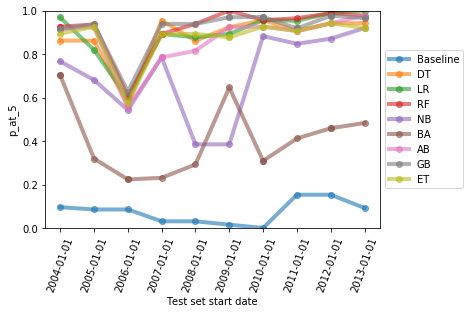

<Figure size 432x288 with 0 Axes>

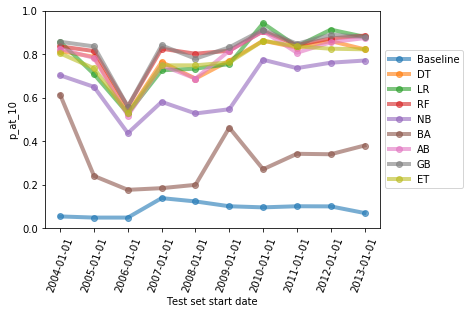

<Figure size 432x288 with 0 Axes>

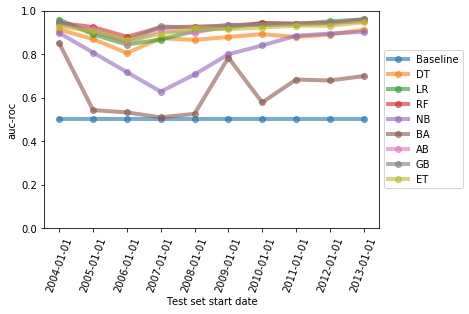

In [257]:
importlib.reload(pipeline)

best_models_per_metric = {}

for metric in metrics_to_display:
    #For each model, find the set of parameters that work the best in each train/test set
    best_models = pipeline.get_best_models_of_each_type_for_each_train_test_set(models_to_run,results,'test_set_start_date', metric)
    pipeline.plot_models_in_time(models_to_run, best_models, metric)
    best_models_per_metric[metric]=best_models
   